# business Problem

#### Objetivo do Problema
    -- Previsão do primeiro destino que um novo usuario irá escolher.

#### Porque?
**Qual tipo de modelo de negócio do AirBNB?**
    
    -- MarketPlace (Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

    -- Tamanho do portfolio
    -- Diversidade/densidade de portfolio
    -- Preço medio

##### Demanda (Pessoas procurando acomodação)

    -- Numero de usuarios
    -- LTV (Lifitime Value)
    -- CAC (Client Acquisition Cost)

**Cross Revenue** (FEE * Numero Cliente) - CAC

#### Proposta da Solução

    -- Modelo de predição do primeiro destino de um novo usuario.

##### Tipos de formatos para entrega do projeto.
    -- Predições salva em tabela do banco de dados.
    -- API: Input: Usuario e suas caracteristicas / Output: Usuario e suas caracteristicas com as Predições do destino.

# Ciclo04: Feature Engineering

# 00 - Imports

In [33]:
import pandas as pd
import random

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras import layers as l

## Paths

In [34]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/models/'
path_transformation = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/transformation_data/'

## Loading Data

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever


In [35]:
data = pd.read_csv(path_data+'train_users_2.csv')
data1 = pd.read_csv(path_data+ 'sessions.csv')

In [36]:
data.head(1).T

,0
id,gxn3p5htnn
date_account_created,2010-06-28
timestamp_first_active,20090319043255
date_first_booking,NaN
gender,-unknown-
age,NaN
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct


# 1.0 Data Description

## Data Dimensions

In [37]:
print("Number of Rows {}".format(data.shape[0]))
print("Number of Rows {}".format(data.shape[1])) 

Number of Rows 213451
Number of Rows 16


In [38]:
print("Number of Rows {}".format(data1.shape[0]))
print("Number of Rows {}".format(data1.shape[1]))

Number of Rows 10567737
Number of Rows 6


## Data Types

In [39]:
data.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [40]:
data1.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## Check NA

In [49]:
data.isnull().sum() / len(data)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [54]:
data1.isnull().sum() / len(data1)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## Treatment NA

### train_users_2.csv (data)

In [43]:
#date_first_booking (Primeiro book do cliente)

aux = data[data['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)
#Conclusão quem não tem destino definido não tem data de book
#Nesse eu tivesse trabalhando no AIRBNB e esse dados fosse atualizado todos os dias, a minha decisão seria colocar a data do dia, no caso a data de hoje,
#pois quando o cliente entrou no site até hoje teria x dias que ele ainda não fez o book, e dessa forma seria calculado essa quantidade de dias como features.
#Como não temos os dados atualizados, iremos utilizar a data maximo, como tivesse fazendo o projeto no ultimo dia dos dados atualizado.

date_first_booking_max = pd.to_datetime(data['date_first_booking']).max().strftime('%Y-%m-%d')
data['date_first_booking'] = data['date_first_booking'].fillna(date_first_booking_max)


/home/wellington/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

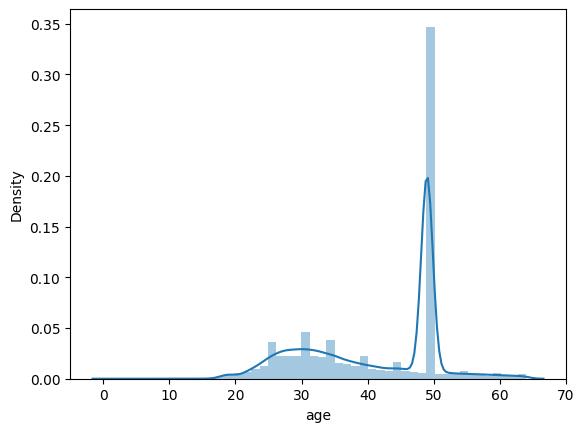

In [44]:
#Column Age

#data['age'].describe()

aux1 = data[data['age'].isna()]
aux1['country_destination'].value_counts(normalize=True)
#Para os dados nulos desta coluna neste ciclo irei utilizar a media, 35 anos. 
data['age'] = data['age'].fillna(data['age'].mean()).astype(int)
sns.distplot(data[data['age'] < 65]['age'])

#Neste caso temos uma distribuição quase normal entre as idades de 20 a 65, temos os dados faltantes distribuidos entre as classe, dessa forma podemos representar esses dados pela media sem estarmos
#colocando vies nos dados.

In [48]:
#first_affiliate_tracked

aux2 = data[data['first_affiliate_tracked'].isna()]
aux2['country_destination'].value_counts(normalize=True)

#Neste variavel temos apenas 3% de dados faltantes, neste caso por ser dados categoricos, prefiro jogar fora do que tentar substituir e acabar inputando um viés nos dados.

data = data[~data['first_affiliate_tracked'].isna()]

### sessions.csv (data1)

In [53]:
#user_id          0.003264
data1 = data1[~data1['user_id'].isna()]

#action           0.007535
data1 = data1[~data1['action'].isna()]

#action_type      0.106570
data1 = data1[~data1['action_type'].isna()]

#action_detail    0.106570
data1 = data1[~data1['action_detail'].isna()]

#device_type      0.000000
data1 = data1[~data1['device_type'].isna()]

#secs_elapsed     0.012872
data1 = data1[~data1['secs_elapsed'].isna()]

## Change data type

In [55]:
#date_account_created 
data['date_account_created'] = pd.to_datetime( data['date_account_created'] )

#timestamp_first_active
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
data['date_first_booking'] = pd.to_datetime(data['date_first_booking'])

#age
data['age'] = data['age'].astype(int)


In [56]:
data.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [57]:
data.sample()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
199526,u6cxnfbtzm,2014-06-04,2014-06-04 15:31:30,2014-06-04,MALE,63,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,US


### Check Balanced Data

In [58]:
data['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

Classe resposta bem desbalanceada, vamos seguir dessa forma para finalizarmos o pipeline com o primeiro ciclo de crisp

# 2.0 Descriptive Statistics

# 3.0 Feature Engineering

# 4.0 Data Filtering

In [14]:
data_filtering = data.copy()

# 5.0 Exploratory data analysis

# 6.0 Data Preparation 

In [15]:
data_preparation = data_filtering.copy()


### GetDummies values

In [16]:
#GetDummies values
data_preparation_dummies = pd.get_dummies(data_preparation.drop(['id', 'country_destination'], axis=1))

# Jooin id And country destination
data_preparation_final = pd.concat( [data_preparation[['id', 'country_destination']], data_preparation_dummies], axis=1)

# 7.0 Feature Selection

In [17]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']

data_selection = data_preparation_final.drop(cols_drop, axis=1)

In [18]:
X = data_selection.drop('country_destination', axis=1)
y = data_selection['country_destination'].copy()

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)

In [20]:
x_train = X_train.drop('id', axis=1)
x_val = X_val.drop('id', axis=1)

In [21]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1)).toarray()